# USDA Python Training

## A Brief Primer on Land/Water Masks

### There are many ways to attempt to produce a land/water mask, but one way that is used (as defined by McFeeters 1996) is calculating NDWI, or Normalized Difference Water Index.

As originally defined, NDWI used the NIR and SWIR bands. This is sensitive to moisture content in leaves.
If we want to look at simple land/water body delineation, then using the McFeeters method, which uses the
Green band in place of SWIR.

There is also the Modified NDWI (or MNDWI), which purports to improve the McFeeters version by replacing NIR with
SWIR. The dataset we're using today does not have SWIR, but does have Green and NIR.

As defined by the index, we are looking at the following ranges for various land/water entities.

| Value | Class |
|-----|-----|
| 0.0 to 0.2 | Humidity/flooding |
| 0.2 to 1.0 | Water surface |
|-0.3 to 0.0 | Moderate drought, non-aqueous surface |
|-1.0 to -0.3 | Drought, non-aqueous surface |

In [2]:
# Open the image file
img = gdal.Open("2021-11-04_Turnage_Florida_Flight2_Clip_BGREN.tif")

# Get our image's geographic information
geotransform = img.GetGeoTransform()
wkt = img.GetProjection()
proj = osr.SpatialReference(wkt)

When reading the raster bands, they are indexed from one, not zero. By using the "ReadAsArray()" function, it places the raster data
into a NumPy array.

In [3]:
# Read in our five bands. Note that you may not need all bands, but for
# availability we're going to bring in all of them.

# This will put the raster values for each band into a NumPy array.

blue = img.GetRasterBand(1).ReadAsArray()
green = img.GetRasterBand(2).ReadAsArray()
red = img.GetRasterBand(3).ReadAsArray()
rededge = img.GetRasterBand(4).ReadAsArray()
nir = img.GetRasterBand(5).ReadAsArray()

In [4]:
# Get our nodata value

# This may actually change based on each band - probably not common, but
# still possible.

nodata = img.GetRasterBand(1).GetNoDataValue()
blue = np.where(blue == nodata, np.nan, blue)
nodata = img.GetRasterBand(2).GetNoDataValue()
green = np.where(green == nodata, np.nan, green)
nodata = img.GetRasterBand(3).GetNoDataValue()
red = np.where(red == nodata, np.nan, red)
nodata = img.GetRasterBand(4).GetNoDataValue()
rededge = np.where(rededge == nodata, np.nan, rededge)
nodata = img.GetRasterBand(5).GetNoDataValue()
nir = np.where(nir == nodata, np.nan, nir)

In [5]:
# The easiest way to change the display scale for imagery is to change the DPI.
# The larger the number, the more it will slow things down.
plt.rcParams['figure.dpi'] = 150

We can plot our imagery right off, but you may end up with issues visualizing if you don't do a histogram stretch
similar to ArcGIS, as we can see below.

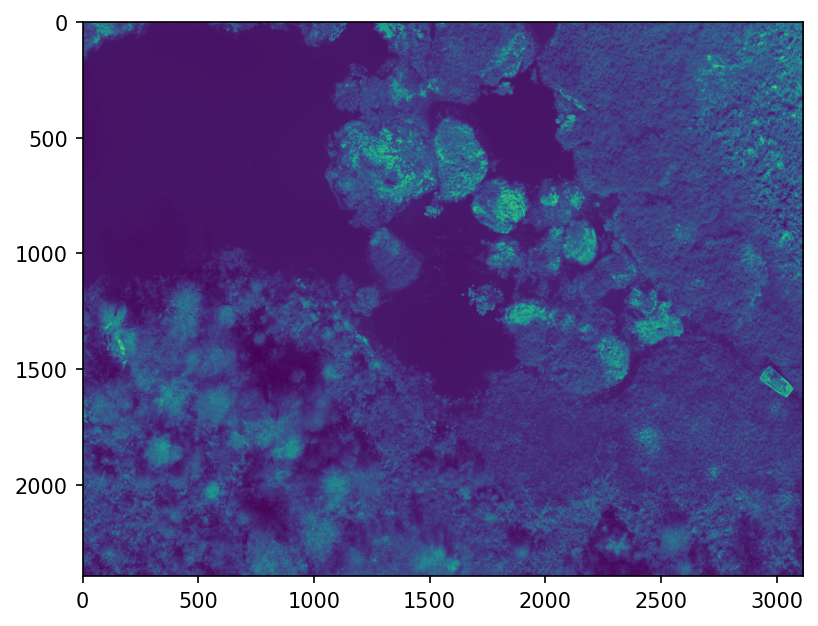

In [6]:
# Let's take a look at our data...
imblue = plt.imshow(blue)

# Looks a bit dark! Let's see if we can address that in the next section.

0.008330717
0.015465911


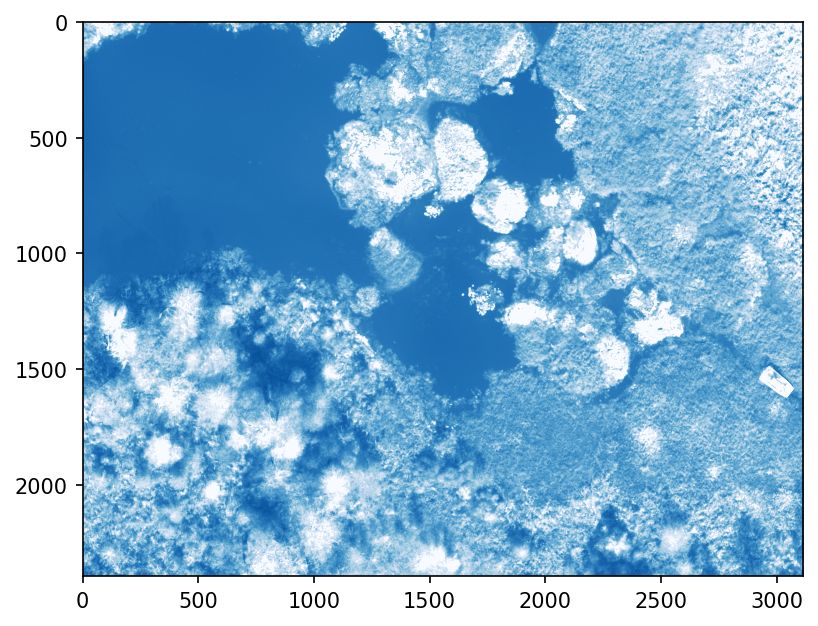

In [7]:
# Grab our standard deviation and mean. Will need it so we can scale our imagery
# more effectively. Currently using two standard deviations.
stdev = np.nanstd(blue)
mean = np.nanmean(blue)

print(stdev)
print(mean)

blue_min_std = mean - (stdev*2)
blue_max_std = mean + (stdev*2)

# This calls our normalization function. The color map can be changed in the imshow
# call - there are many built-in options, and custom color maps can also be used.
normalize = colors.Normalize(vmin=blue_min_std, vmax=blue_max_std, clip=True)
imblue = plt.imshow(blue, cmap='Blues_r', norm=normalize)

0.010773428
0.016607633


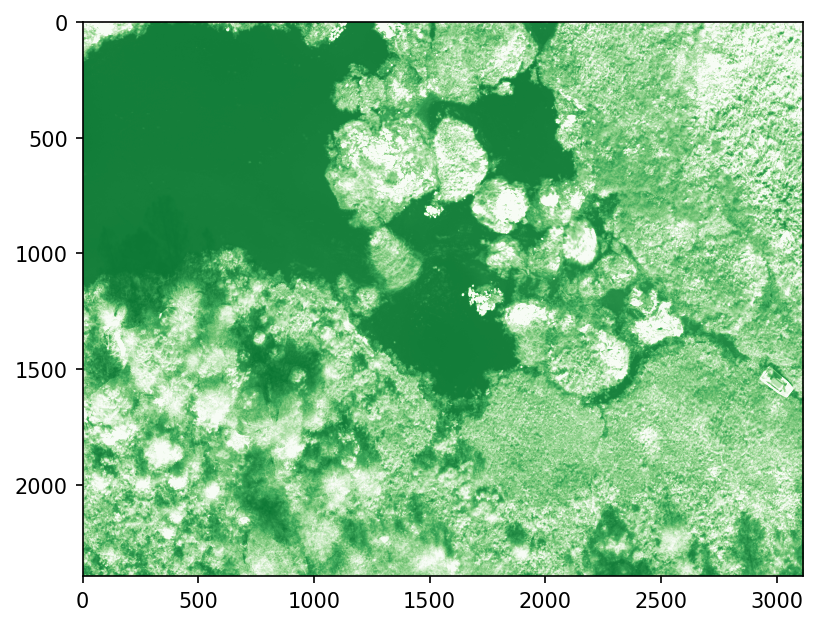

In [8]:
# Repeating for each band.

stdev = np.nanstd(green)
mean = np.nanmean(green)

print(stdev)
print(mean)

green_min_std = mean - (stdev*2)
green_max_std = mean + (stdev*2)

normalize = colors.Normalize(vmin=green_min_std, vmax=green_max_std, clip=True)
imgreen = plt.imshow(green, cmap='Greens_r', norm=normalize)

0.011301483
0.015996708


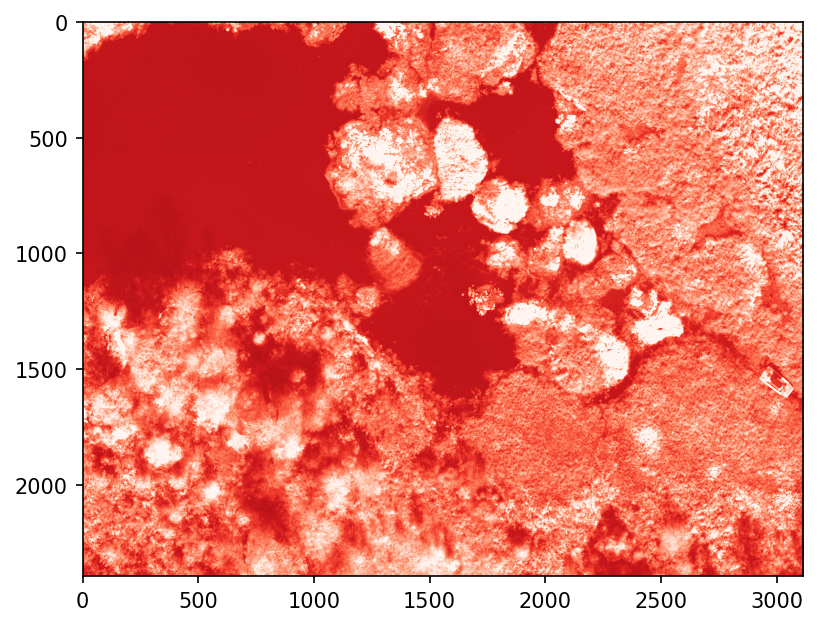

In [9]:
stdev = np.nanstd(red)
mean = np.nanmean(red)

print(stdev)
print(mean)

red_min_std = mean - (stdev*2)
red_max_std = mean + (stdev*2)

normalize = colors.Normalize(vmin=red_min_std, vmax=red_max_std, clip=True)
imred = plt.imshow(red, cmap='Reds_r', norm=normalize)

0.025501098
0.0362033


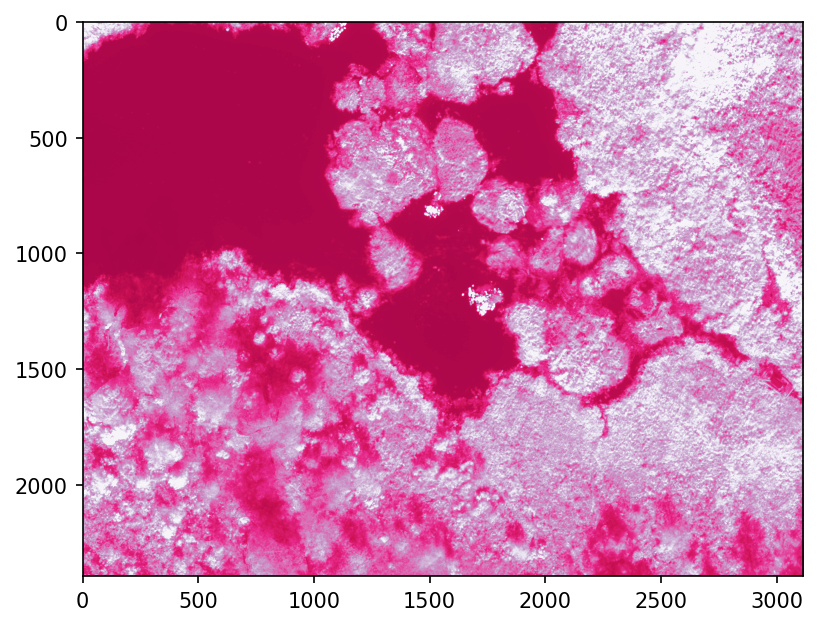

In [10]:
stdev = np.nanstd(rededge)
mean = np.nanmean(rededge)

print(stdev)
print(mean)

rededge_min_std = mean - (stdev*2)
rededge_max_std = mean + (stdev*2)

normalize = colors.Normalize(vmin=rededge_min_std, vmax=rededge_max_std, clip=True)
imrededge = plt.imshow(rededge, cmap='PuRd_r', norm=normalize)

0.0453925
0.061932974


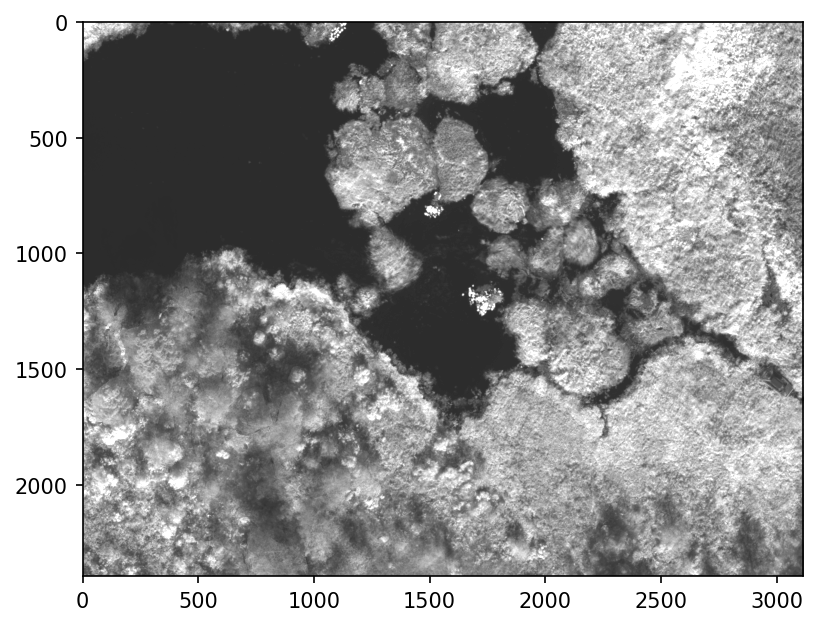

In [11]:
stdev = np.nanstd(nir)
mean = np.nanmean(nir)

print(stdev)
print(mean)

nir_min_std = mean - (stdev*2)
nir_max_std = mean + (stdev*2)

normalize = colors.Normalize(vmin=nir_min_std, vmax=nir_max_std, clip=True)
imnir = plt.imshow(nir, cmap='gray', norm=normalize)

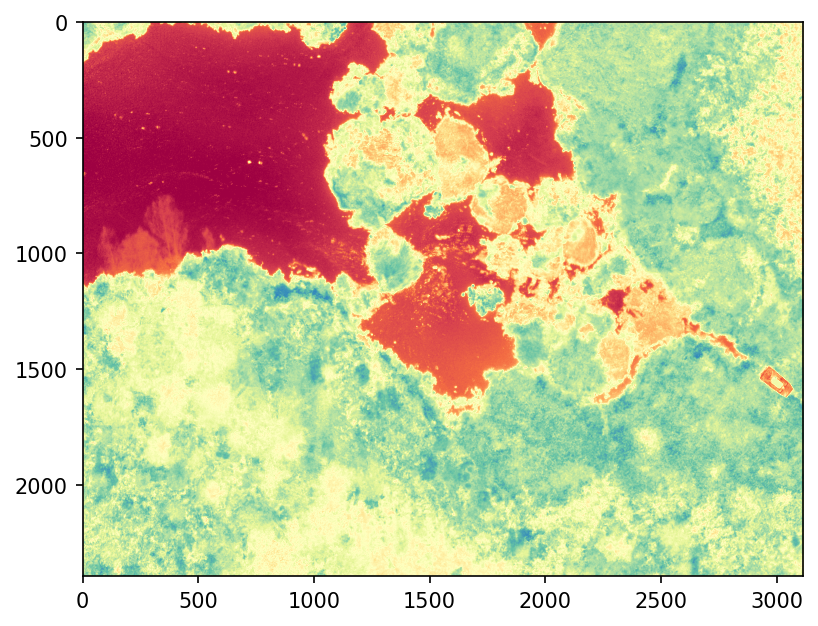

In [12]:
# Can compute NDVI if we're interesting in looking for vegetation.

# NDVI is (NIR - Red)/(NIR + Red)

ndvi = np.divide((nir - red),(nir + red))
stdev = np.nanstd(ndvi)
mean = np.nanmean(ndvi)

normalize = colors.Normalize(vmin=(mean - (stdev*2)), vmax=(mean + (stdev*2)), clip=True)
imndvi = plt.imshow(ndvi, cmap='Spectral', norm=normalize)

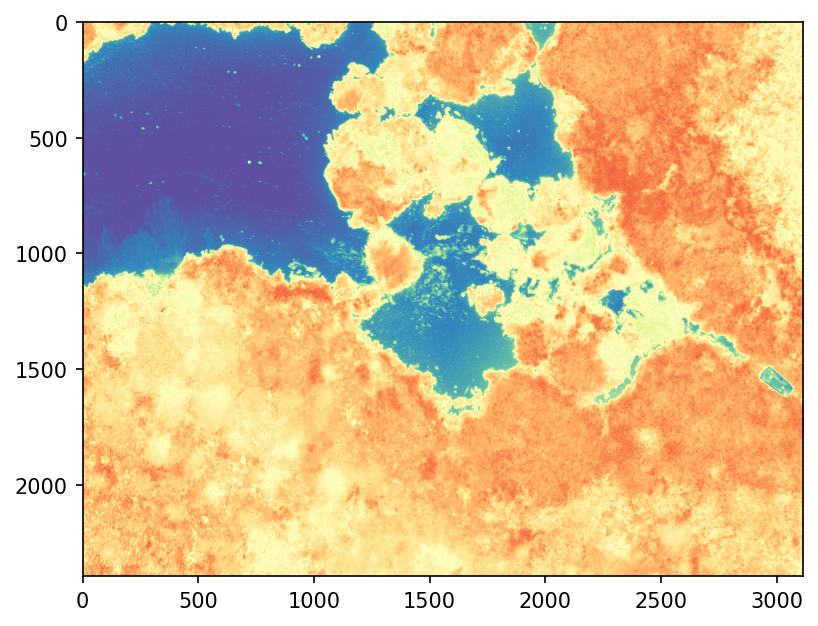

In [13]:
# Let's see about doing a simple land/water mask. Note that these can be notoriously tricky based
# on various factors such as sun glint, water turbidity, sedimentation, algal content, etc.

# First, let's create a NDWI image. There are two versions of NDWI, one of which uses SWIR and the other
# which uses the green band. We don't have SWIR, but that's primarily to look for water content in leaves,
# whereas the green band version looks for water in water bodies, which is what we want.

# NDWI is (Green - NIR)/(Green + NIR)
ndwi = (green - nir) / (green + nir)
stdev = np.nanstd(ndwi)
mean = np.nanmean(ndwi)

normalize = colors.Normalize(vmin=(mean - (stdev*2)), vmax=(mean + (stdev*2)), clip=True)
imndwi = plt.imshow(ndwi, cmap='Spectral', norm=normalize)

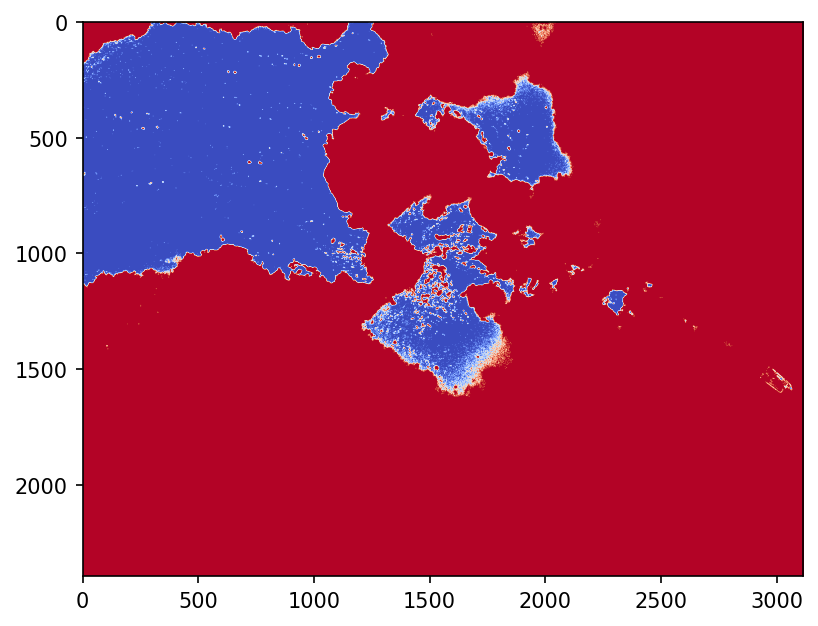

In [14]:
# Using somewhat arbitrary thresholds, let's compute a land/water mask. NDWI defines greater than zero
# as water. We'll also use our NIR band as well to apply a little extra filtering - sometimes NDWI can
# give some false readings, and NIR will help make sure we're not looking at something that's highly
# reflective in the NIR band (possibly in urban environments).

classified = np.where(((nir <= 0.1) & (ndwi >= 0)), 1, 2)
classified = np.where(np.isnan(nir), nir, classified)
imclass = plt.imshow(classified, cmap='coolwarm')

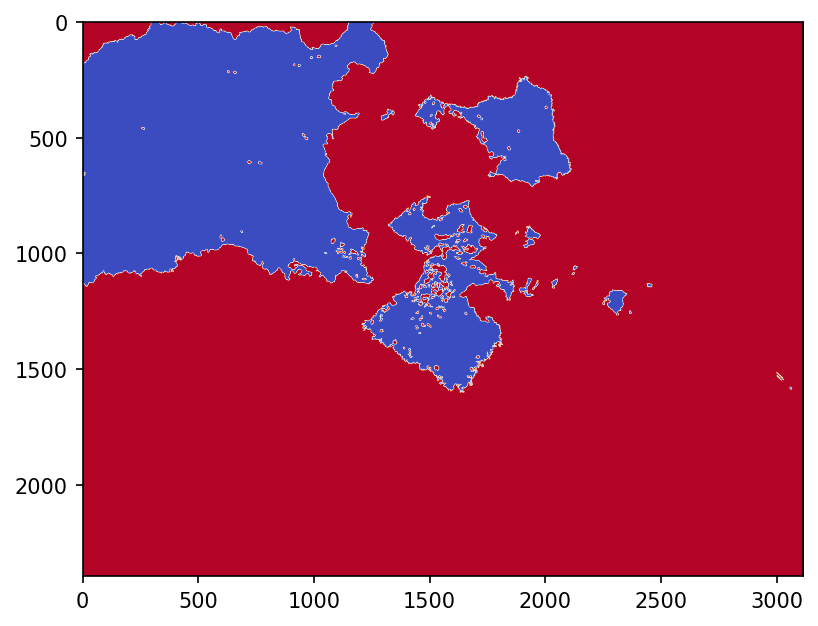

In [15]:
# We're going to try to filter our imagery a bit more, as this is a bit noisy-looking.


# First, we're going to take everywhere that is a NumPy NaN and turn back to zero. This will
# effectively become our nodata value.
classified_nodata = np.where(np.isnan(classified), 0, classified)

# We need to create a temporary GeoTIFF file to store our results in. Be careful with this,
# as the rows and columns may be transposed from what the NumPy array holds currently.
driver = gdal.GetDriverByName('GTiff')
outdata = driver.Create('{}'.format("filter.tif"), classified.shape[1], classified.shape[0], 1, \
                        gdal.GDT_Byte, options=['COMPRESS=DEFLATE'])

# Write our modified classified array to the GeoTIFF we just created, and make sure to add
# in our georeferencing as well.
outdata.GetRasterBand(1).WriteArray(classified_nodata)
outdata.SetGeoTransform(geotransform)
srs = osr.SpatialReference()
srs.ImportFromWkt(wkt)
outdata.SetProjection(srs.ExportToWkt())

# Now we're going to use GDAL's SieveFilter function to group pixels. There are several options to
# change here, but we will stick with a connectedness of 4 (don't consider diagonal pixels adjacent),
# and a threshold value of 50 (groups of pixels smaller than 50 will be disregarded).

gdal.SieveFilter(srcBand=outdata.GetRasterBand(1), maskBand=None, dstBand=outdata.GetRasterBand(1), threshold=50, connectedness=4)
outdata.GetRasterBand(1).SetNoDataValue(0)
outdata.FlushCache()

# Let's take a look at the results!
flt = gdal.Open("filter.tif")
fltimg = flt.GetRasterBand(1).ReadAsArray()
nodata = flt.GetRasterBand(1).GetNoDataValue()
fltimg = np.where(fltimg == nodata, np.nan, fltimg)
imflt = plt.imshow(fltimg, cmap='coolwarm')

In [16]:
# Convert GeoTIFF to shapefile.

# Jupyter notebook tends to hold on to this file, so need to manually delete if re-running
# this is desired.

if not os.path.exists("filter.shp"):
    
    dstlayername = "filter.shp"
    drv = ogr.GetDriverByName("ESRI Shapefile")
    dstds = drv.CreateDataSource(dstlayername)

    # Make sure that a value field exists in the shapefile so that when we call
    # Polygonize the values will migrate over.
    dstlayer = dstds.CreateLayer(dstlayername, srs=srs, geom_type=ogr.wkbMultiPolygon)
    datafield = ogr.FieldDefn('Value', ogr.OFTInteger)
    dstlayer.CreateField(datafield)
    dstfield = dstlayer.GetLayerDefn().GetFieldIndex("Value")
    
    # Call Polygonize to change the raster to polygons. The "8CONNECTEDNESS" field may not
    # be necessary depending on how you want to group pixels (only adjacent in four cardinal
    # directions or also on diagonals).
    gdal.Polygonize(flt.GetRasterBand(1), None, dstlayer, dstfield, ["8CONNECTEDNESS=8"], callback=None)
    dstds.SyncToDisk()
    dstds=None

In [17]:
# Now perhaps we want to simplify this shapefile to be a bit less pixelated.

dstlayername = "filter_simple.shp"
drv = ogr.GetDriverByName("ESRI Shapefile")
dstds = drv.CreateDataSource(dstlayername)
dstlayer = dstds.CreateLayer(dstlayername, srs=srs, geom_type=ogr.wkbMultiPolygon)

# We want to keep all our fields from the prior shapefile, so create both fields
# to match, including FID.
datafield = ogr.FieldDefn('Value', ogr.OFTInteger)
dstlayer.CreateField(datafield)
datafield = ogr.FieldDefn('FID', ogr.OFTInteger)
dstlayer.CreateField(datafield)

shp = ogr.Open('filter.shp')
# Grab the layer.
layer = shp.GetLayer()
# Find out how many features (polygons) are in our layer.
numfeatures = layer.GetFeatureCount()

# Iterate through each feature in the shapeifle and simplify the geometry.
# Note that this may actually completely remove some shapes.
for i in range(0, numfeatures):
    feature = layer.GetFeature(i)
    geometry = feature.geometry()
    feature.SetGeometry(geometry.Simplify(0.1))
    dstlayer.CreateFeature(feature)
    #print(filter_simple)
    #print(geometry)

dstds.SyncToDisk()
dstds=None
shp=None